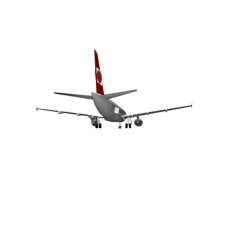

In [24]:
import matplotlib.pyplot as plt
import dataset

path = "dataset/test/test_data/873f4d2e92681d12709eb7790ef48e0c/models/model_normalized.obj"
mat = dataset.geometry.random_camera()
color = dataset.rendering.render(path, mat)
plt.figure()
plt.axis('off')
plt.imshow(color)
plt.show()

In [286]:
image_path = "planes/222c0d99446148babe4274edc10c1c8e/render_00010.png"

In [291]:
image_path[:-16]

'planes/222c0d99446148babe4274edc10c1c8e/'

In [97]:
def make_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
        
def make_dataset(input_path, output_path, size=128, nb_points=100000, number_models=None, nb_samples_per_model=20):
    make_dir(output_path)
    objects_path = os.path.join(input_path, "*/models/*.obj")
    objects_path = glob.glob(objects_path)
    if number_models is not None:
        objects_path = objects_path[:number_models]
    for path in tqdm.tqdm(objects_path):
        name = path.split(os.path.sep)[-3]
        object_dir = os.path.join(output_path, name)
        make_dir(object_dir)
        for i in range(nb_samples_per_model):
            render_name = f"render_{str(i).zfill(5)}"
            mat_name = f"mat_{str(i).zfill(5)}"
            image_path = os.path.join(object_dir, render_name + ".jpg") 
            mat_path = os.path.join(object_dir, render_name + ".pkl") 
            mat = dataset.geometry.random_camera()
            
            try:
                color = dataset.rendering.render(path, mat)
            except OpenGL.error.GLError:
                print("GL Error occured, trying again.")
                color = dataset.rendering.render(path, mat)
            
            im = Image.fromarray(color)
            im.save(image_path)
            with open(mat_path, 'wb') as handle:
                pickle.dump(mat, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
planes_input = objects_path = "/Data/leo/download/ShapeNetCore.v2/02691156/"
planes_output = "data/planes"
try:
    make_dataset(planes_input, planes_output, number_models=10)
except Exception as e:
    print(e)
    print(type(e))
    

KeyboardInterrupt: 

In [20]:
import os
os.environ["PYOPENGL_PLATFORM"] = "egl"
import numpy as np
import trimesh
import pyrender

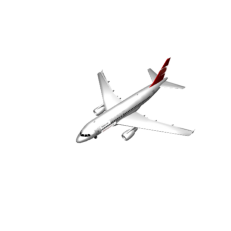

In [42]:
path = "dataset/test/test_data/873f4d2e92681d12709eb7790ef48e0c/models/model_normalized.obj"
mat = dataset.geometry.random_camera()
color = dataset.rendering.render(path, mat)
plt.figure()
plt.axis('off')
plt.imshow(color)
plt.show()

In [119]:
path = files[np.random.randint(len(files))]

In [120]:
path

'/Data/leo/download/ShapeNetCore.v2/02691156/a87cad03c8f717e230dd29e8b6a554b3/models/model_normalized.obj'

In [149]:
m = np.random.uniform(size=(2,3,4))
m

array([[[0.98752746, 0.97124897, 0.41593374, 0.59110335],
        [0.95399987, 0.93758002, 0.91130648, 0.52619814],
        [0.39113429, 0.01952181, 0.35551098, 0.12902094]],

       [[0.33450128, 0.65217525, 0.84068467, 0.17830894],
        [0.18929205, 0.91129099, 0.42860611, 0.38396308],
        [0.16553976, 0.41095228, 0.52909531, 0.50766467]]])

In [154]:
np.take(m,[1,0],axis=0)

array([[[0.33450128, 0.65217525, 0.84068467, 0.17830894],
        [0.18929205, 0.91129099, 0.42860611, 0.38396308],
        [0.16553976, 0.41095228, 0.52909531, 0.50766467]],

       [[0.98752746, 0.97124897, 0.41593374, 0.59110335],
        [0.95399987, 0.93758002, 0.91130648, 0.52619814],
        [0.39113429, 0.01952181, 0.35551098, 0.12902094]]])

In [258]:
for path in tqdm.tqdm(files):
    fuze_trimesh = trimesh.load(path)
    assert type(fuze_trimesh) == trimesh.scene.scene.Scene

AssertionError: 

In [282]:
def get_vertices(path):
    fuze_trimesh = trimesh.load(path)
    points = []
    if type(fuze_trimesh) == trimesh.scene.scene.Scene:
        for key in fuze_trimesh.geometry:
            points.append(fuze_trimesh.geometry[key].vertices)
    else:
        assert type(fuze_trimesh) == trimesh.base.Trimesh
        points.append(fuze_trimesh.vertices)
    return np.concatenate(points)

def get_area(triangles):
    v1 = triangles[:,1] - triangles[:,0]
    v2 = triangles[:,2] - triangles[:,1]
    area = np.linalg.norm(np.cross(v1,v2), axis=1)
    return area

def sample_points(path, nb=10000):
    fuze_trimesh = trimesh.load(path)
    triangles = []
    if type(fuze_trimesh) == trimesh.scene.scene.Scene:
        for key in fuze_trimesh.geometry:
            triangles.append(fuze_trimesh.geometry[key].triangles)
    else:
        assert type(fuze_trimesh) == trimesh.base.Trimesh
        triangles.append(fuze_trimesh.triangles)
    triangles = np.concatenate(triangles)
    area = get_area(triangles)
    proba = area / np.sum(area)
    samples = np.random.choice(len(proba), size=nb, p=proba)
    coord = np.random.uniform(size=(nb, 3, 1))
    coord = coord / np.sum(coord, axis=1, keepdims=True)
    basis = np.take(triangles, samples, axis=0)
    points = np.sum(coord*basis, axis=1)
    return points

def mult_vec(mat, vec):
    v = np.ones((len(vec),4))
    v[:,:3] = vec
    return (v@mat)[:,:3]

#pts = get_vertices(path)
pts = sample_points(path, 1000)
pts = mult_vec(mat, pts)

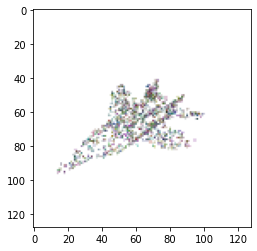

In [284]:
colors = np.random.uniform(size=pts.shape)
m = pyrender.Mesh.from_points(pts, colors=colors)
scene = pyrender.Scene()
scene.add_node(pyrender.Node(mesh=m))
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
s = np.sqrt(2)/2
mat_default = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,1],
    [0,0,0,1],
])
scene.add(camera, pose=mat_default)

light = pyrender.SpotLight(color=np.ones(3), intensity=4.0,
                           innerConeAngle=np.pi/16.0)
scene.add(light, pose=mat_default)
light = pyrender.SpotLight(color=np.ones(3), intensity=6.0,
                           innerConeAngle=0.2*np.pi)
light_pose = np.array([
    [0,1,0,0],
    [0,0,1,1],
    [1,0,0,0],
    [0,0,0,1]
], dtype=np.float32)
scene.add(light, pose=light_pose)
r = pyrender.OffscreenRenderer(128, 128)
try :
    color2, depth = r.render(scene)
    plt.imshow(color2)
except Exception as e:
    print(type(e))
    

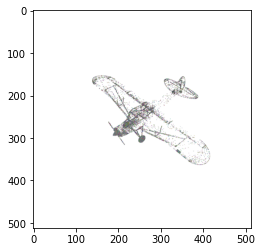

In [226]:
plt.imshow(color2)

In [98]:
files = glob.glob("/Data/leo/download/ShapeNetCore.v2/02691156/*/models/model_normalized.obj")